# DATA

In [20]:
import imgaug as ia
import imgaug.augmenters as iaa
import imageio
import json
import os
import cv2
import numpy as np
import os 
import json
import matplotlib.pylab as plt
import shutil
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from os import listdir
from glob import glob


p = os.getcwd() 

In [21]:
#json -> yolo txt
def convert(path, label):
    with open(label) as f:
        json_data = json.load(f)
    if json_data['annotations']['area'] == 3:
        file_name = json_data['description']['image'].split('.')[0]
        xtl = json_data['annotations']['points'][0]['xtl']
        ytl = json_data['annotations']['points'][0]['ytl']
        xbr = json_data['annotations']['points'][0]['xbr']
        ybr = json_data['annotations']['points'][0]['ybr']

        w = json_data['description']['width']
        h = json_data['description']['height']

        x_center = (xtl + (xbr-xtl)/2)/w
        y_center = (ytl + (ybr-ytl)/2)/h
        x = (xbr-xtl)/w
        y = (ybr-ytl)/h

        area = json_data['annotations']['area']
        name = json_data['annotations']['disease']
        risk = json_data['annotations']['risk']
        grow = json_data['annotations']['grow']
        


        if name == 0:
            if grow == 11:
                c = 0
            else:
                c = 1
        elif name == 5:
            c = risk + 1
        elif name == 6:
            c = 4 + risk
        fw = open(path+file_name+".txt", 'w')
        fw.write(str(c)+' '+str(round(x_center,6))+' '+str(round(y_center,6))+' '+str(round(x,6))+' '+str(round(y,6))+'\n')
        f.close()
        #print(file_name)
    else:
        os.remove(label)
        # print(label)


In [22]:
#분포
def distribution(label,lst):
    with open(label,'r') as f:
        read = f.read(1)
        lst.append(read)
    return lst

def distribution2(lst,dic):
    for i in lst:
        try: dic[i] += 1
        except: dic[i] = 1
    fa = sorted(dic.items())
    return fa

In [23]:
#그래프 표시
def grape(x,y):
    plt.bar(x,y)
    for k, v in enumerate(x):
        plt.text(v, y[k], y[k],                 
             fontsize = 9, 
             color='red',
             horizontalalignment='center',  
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    plt.show


In [24]:
#데이터 분석
def Data_analysis(img, label):
    img_disease = img.split('_')[3]
    with open(label) as f:
        json_data = json.load(f)
    label_disease = json_data['annotations']['disease']
    if int(img_disease) != label_disease:
        os.remove(img)
        os.remove(label)

In [25]:
#데이터 지우기
def Data_remove(img, txt, json, dic, cnt):
    i = 0
    for file in txt:
        with open(txt[i],'r') as f:
            read = f.read(1)
        if dic[read] == int(cnt):
            i = i + 1
            pass
        else:
            print(read)
            print(img[i])
            print(txt[i])
            os.remove(img[i])
            os.remove(txt[i])
            os.remove(json[i])
            dic[read] = dic[read] - 1
            print(dic)
            i = i + 1

In [26]:
#회전
def rotation(img_path,txt_path, image, label):
    with open(label) as f:
        json_data = json.load(f)
    image = cv2.imread(image)

    
    xtl = json_data['annotations']['points'][0]['xtl']
    ytl = json_data['annotations']['points'][0]['ytl']
    xbr = json_data['annotations']['points'][0]['xbr']
    ybr = json_data['annotations']['points'][0]['ybr']
    w = json_data['description']['width']
    h = json_data['description']['height']
    
    name = json_data['annotations']['disease']
    risk = json_data['annotations']['risk']
    grow = json_data['annotations']['grow']

    if name == 0:
        if grow == 11:
            c = 0
        else:
            c = 1
    elif name == 5:
        c = risk + 1
    elif name == 6:
        c = 4 + risk

    bf = []
    bf.append([int(xtl), int(ytl), int(xbr), int(ybr)])
    ia_bf = []
    for box in bf:
        ia_bf.append(ia.BoundingBox(x1=box[0],y1=box[1],x2=box[2],y2=box[3],label = c))
        
    bbs = ia.BoundingBoxesOnImage(ia_bf, shape = image.shape)
    name2 = label.split('\\')[-1]
    name_re = name2.split('.')[0]

    for j in range(0, 4):
        rtt = 90*j
        seq = iaa.Sequential([
            iaa.Affine(rotate=rtt)
            
        ])
        img_aug, bbs_aug = seq(image = image,bounding_boxes = bbs)
        
        x1 = bbs_aug.bounding_boxes[0].x1
        y1 = bbs_aug.bounding_boxes[0].y1
        x2 = bbs_aug.bounding_boxes[0].x2
        y2 = bbs_aug.bounding_boxes[0].y2
            
        w = bbs_aug.shape[1]
        h = bbs_aug.shape[0]
        # print(name2)
        # print(bbs_aug)
        # print(j)
        x_center = (x1 + (x2-x1)/2)/w
        y_center = (y1 + (y2-y1)/2)/h
        x = (x2-x1)/w
        y = (y2-y1)/h
        # # image_after = bbs_aug.draw_on_image(img_aug, thickness=10, color = [0, 0, 255])
        cv2.imwrite(img_path+str(j)+'-'+name_re+'.jpg',img_aug)
        fw = open(txt_path+str(j)+'-'+name_re+".txt", 'w')
        fw.write(str(c)+' '+str(round(x_center,6))+' '+str(round(y_center,6))+' '+str(round(x,6))+' '+str(round(y,6))+'\n')
        f.close()
            
        # # cv2_imshow(cv2.resize(image_after, (w,h)))
        print('c = '+str(c))

In [27]:
#크기
def size(img_path,txt_path, image, label):
    with open(label) as f:
        json_data = json.load(f)
    image = cv2.imread(image)

    
    xtl = json_data['annotations']['points'][0]['xtl']
    ytl = json_data['annotations']['points'][0]['ytl']
    xbr = json_data['annotations']['points'][0]['xbr']
    ybr = json_data['annotations']['points'][0]['ybr']
    w = json_data['description']['width']
    h = json_data['description']['height']
    
    name = json_data['annotations']['disease']
    risk = json_data['annotations']['risk']
    grow = json_data['annotations']['grow']

    if name == 0:
        if grow == 11:
            c = 0
        else:
            c = 1
    elif name == 5:
        c = risk + 1
    elif name == 6:
        c = 4 + risk

    bf = []
    bf.append([int(xtl), int(ytl), int(xbr), int(ybr)])
    ia_bf = []
    for box in bf:
        ia_bf.append(ia.BoundingBox(x1=box[0],y1=box[1],x2=box[2],y2=box[3],label = c))
        
    bbs = ia.BoundingBoxesOnImage(ia_bf, shape = image.shape)
    name2 = label.split('\\')[-1]
    name_re = name2.split('.')[0]
    print('c = '+str(c))
    for j in range(1):
        seq = iaa.Sequential([
            iaa.Affine(scale=(0.5,0.7))
            
        ])
        img_aug, bbs_aug = seq(image = image,bounding_boxes = bbs)
        
        x1 = bbs_aug.bounding_boxes[0].x1
        y1 = bbs_aug.bounding_boxes[0].y1
        x2 = bbs_aug.bounding_boxes[0].x2
        y2 = bbs_aug.bounding_boxes[0].y2
            
        w = bbs_aug.shape[1]
        h = bbs_aug.shape[0]

        x_center = (x1 + (x2-x1)/2)/w
        y_center = (y1 + (y2-y1)/2)/h
        x = (x2-x1)/w
        y = (y2-y1)/h
        
        if x_center > 1:
            x_center = 1
        if y_center > 1:
            y_center = 1
        if x > 1:
            x = 1
        if y > 1:
            y = 1
        # # image_after = bbs_aug.draw_on_image(img_aug, thickness=10, color = [0, 0, 255])
        cv2.imwrite(img_path+'s-'+name_re+'.jpg',img_aug)
        fw = open(txt_path+'s-'+name_re+".txt", 'w')
        fw.write(str(c)+' '+str(round(x_center,6))+' '+str(round(y_center,6))+' '+str(round(x,6))+' '+str(round(y,6)))
        f.close()
            
        # # cv2_imshow(cv2.resize(image_after, (w,h)))
        print('c = '+str(c))

In [28]:
#밝기
def color_brightness(img_path, txt_path, name, img, label, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    h, s, v = cv2.split(hsv) 
    
    lim = 255 - value 
    v[v > lim] = 255 
    v[v <= lim] += value 
    
    final_hsv = cv2.merge((h, s, v)) 
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


    cv2.imwrite(img_path+'c'+name+'.jpg', img)

    shutil.copyfile(label, txt_path +'c'+name+'.txt')

In [29]:
#블러
def blurs(img_path, txt_path, name, img, label):
    blur1 = cv2.GaussianBlur(img,(0,0),3)
    cv2.imwrite(img_path+'g'+name+'.jpg', blur1)
    
    shutil.copyfile(label, txt_path +'g'+name+'.txt')
    
    blur2 = cv2.medianBlur(img, 5)
    cv2.imwrite(img_path+'m'+name+'.jpg', blur2)
    
    
    shutil.copyfile(label, txt_path +'m'+name+'.txt')

In [30]:
#img_remove
def img_remove(img):
    if img.split('_')[5] == '05':
        os.remove(img)
        # print(img)

# __DATA__

In [31]:
%cd ./desktop/swproject


[WinError 3] 지정된 경로를 찾을 수 없습니다: './desktop/swproject'
c:\Users\oo\Desktop\swproject


In [32]:
#폴더생성
%cd ./
os.mkdir("test")
%cd ./test/
os.mkdir("train")
os.mkdir("valid")
%cd ./train/
os.mkdir("images")
os.mkdir("labels")
%cd ..
%cd ./valid/
os.mkdir("images")
os.mkdir("labels")
%cd ..
%cd ..



c:\Users\oo\Desktop\swproject
c:\Users\oo\Desktop\swproject\test
c:\Users\oo\Desktop\swproject\test\train
c:\Users\oo\Desktop\swproject\test
c:\Users\oo\Desktop\swproject\test\valid
c:\Users\oo\Desktop\swproject\test
c:\Users\oo\Desktop\swproject


In [33]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

18008 2059 18008 2059 0 0
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [34]:
#데이터 분석
for i in range(len(train_img)):
    Data_analysis(train_img[i],train_label_json[i])

for i in range(len(valid_img)):
    Data_analysis(valid_img[i],valid_label_json[i])


In [35]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

17964 2015 17964 2015 0 0
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [36]:
# json -> txt
import os 
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
for i in range(len(train_label_json)):
    convert(t,train_label_json[i])

for i in range(len(valid_label_json)):
    convert(v,valid_label_json[i])
    
train_label_txt = glob(p+'/datasets/train/labels/*')
valid_label_txt = glob(p+'/datasets/valid/labels/*')
print(len(train_label_txt), len(valid_label_txt))

17046 1904


In [37]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p + '\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')


img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p+'\\test\\train\\images\\'
txt_path_t = p+'\\test\\train\\labels\\'

img_path_v = p+'\\test\\valid\\images\\'
txt_path_v = p+'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

17964 2015 17046 1904 17046 1904
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [38]:
#img_remove
for i in range(len(train_img)):
    img_remove(train_img[i])

for i in range(len(valid_img)):
    img_remove(valid_img[i])

In [39]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p + '\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')


img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p+'\\test\\train\\images\\'
txt_path_t = p+'\\test\\train\\labels\\'

img_path_v = p+'\\test\\valid\\images\\'
txt_path_v = p+'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

17046 1904 17046 1904 17046 1904
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [40]:
#데이터 확인
for i in range(len(train_img)):
    a = train_label_json[i].split('\\')[-1]
    aa = a.split('.')[0]
    b = train_img[i].split('\\')[-1]
    bb = b.split('.')[0]
    c = train_label_txt[i].split('\\')[-1]
    cc = c.split('.')[0]
    if aa != cc or aa!=bb:
        print(f'a={aa} \nb={c}')


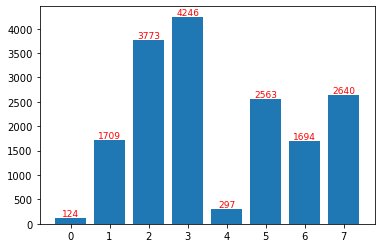

In [41]:
#분포 train
d_train = []
d_train2 = {}

for i in range(len(train_label_txt)):
    distribution(train_label_txt[i],d_train)

trainx, trainy = zip(*distribution2(d_train,d_train2))

grape(trainx, trainy)


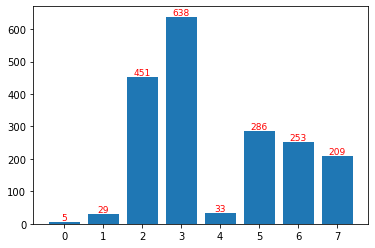

In [42]:
#분포 valid
d_valid = []
d_valid2 = {}

for i in range(len(valid_label_txt)):
    distribution(valid_label_txt[i],d_valid)

validx, validy = zip(*distribution2(d_valid,d_valid2))

grape(validx, validy)


In [43]:
#DATA_REMOVE
Data_remove(train_img, train_label_txt, train_label_json, d_train2, 100)
Data_remove(valid_img, valid_label_txt, valid_label_json, d_valid2, 5)


0
c:\Users\oo\Desktop\swproject\datasets\train\images\V006_77_0_00_03_03_11_0_c14_20201119_0000_S01_1.jpg
c:\Users\oo\Desktop\swproject\datasets\train\labels\V006_77_0_00_03_03_11_0_c14_20201119_0000_S01_1.txt
{'0': 123, '1': 1709, '2': 3773, '3': 4246, '4': 297, '5': 2563, '6': 1694, '7': 2640}
0
c:\Users\oo\Desktop\swproject\datasets\train\images\V006_77_0_00_03_03_11_0_c14_20201119_0001_S01_1.jpg
c:\Users\oo\Desktop\swproject\datasets\train\labels\V006_77_0_00_03_03_11_0_c14_20201119_0001_S01_1.txt
{'0': 122, '1': 1709, '2': 3773, '3': 4246, '4': 297, '5': 2563, '6': 1694, '7': 2640}
0
c:\Users\oo\Desktop\swproject\datasets\train\images\V006_77_0_00_03_03_11_0_c14_20201119_0002_S01_1.jpg
c:\Users\oo\Desktop\swproject\datasets\train\labels\V006_77_0_00_03_03_11_0_c14_20201119_0002_S01_1.txt
{'0': 121, '1': 1709, '2': 3773, '3': 4246, '4': 297, '5': 2563, '6': 1694, '7': 2640}
0
c:\Users\oo\Desktop\swproject\datasets\train\images\V006_77_0_00_03_03_11_0_c14_20201119_0003_S01_1.jpg
c:\

In [44]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p + '\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')


img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p+'\\test\\train\\images\\'
txt_path_t = p+'\\test\\train\\labels\\'

img_path_v = p+'\\test\\valid\\images\\'
txt_path_v = p+'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

800 40 800 40 800 40
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [45]:
#데이터 확인
for i in range(len(train_img)):
    a = train_label_json[i].split('\\')[-1]
    aa = a.split('.')[0]
    b = train_img[i].split('\\')[-1]
    bb = b.split('.')[0]
    c = train_label_txt[i].split('\\')[-1]
    cc = c.split('.')[0]
    if aa != cc or aa!=bb:
        print(f'a={aa} \nb={c}')
        
for i in range(len(valid_img)):
    va = valid_label_json[i].split('\\')[-1]
    vaa = a.split('.')[0]
    vb = valid_img[i].split('\\')[-1]
    vbb = b.split('.')[0]
    vc = valid_label_txt[i].split('\\')[-1]
    vcc = c.split('.')[0]
    if aa != cc or aa!=bb:
        print(f'a={aa} \nb={c}')


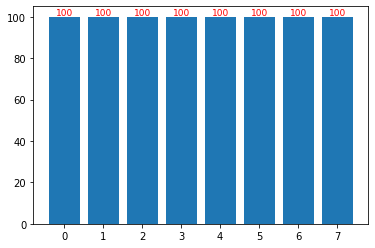

In [46]:
#분포 train
d_train = []
d_train2 = {}

for i in range(len(train_label_txt)):
    distribution(train_label_txt[i],d_train)

trainx, trainy = zip(*distribution2(d_train,d_train2))

grape(trainx, trainy)


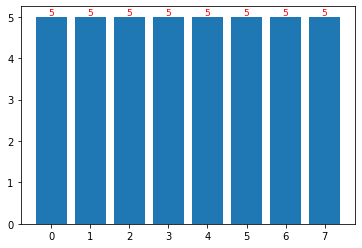

In [47]:
#분포 valid
d_valid = []
d_valid2 = {}

for i in range(len(valid_label_txt)):
    distribution(valid_label_txt[i],d_valid)

validx, validy = zip(*distribution2(d_valid,d_valid2))

grape(validx, validy)


In [48]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

800 40 800 40 800 40
0 0
-----------------------------------------------------------------------------------------
0 0 0 0


In [49]:
#ROTATION/ SIZE

for i in range(len(train_img)):
    rotation(img_path_t, txt_path_t ,train_img[i],train_label_json[i])
    size(img_path_t, txt_path_t ,train_img[i],train_label_json[i])
    
for i in range(len(valid_img)):
    rotation(img_path_v, txt_path_v ,valid_img[i],valid_label_json[i])
    size(img_path_v, txt_path_v ,valid_img[i],valid_label_json[i])

c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 0
c = 

In [50]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

800 40 800 40 800 40
4000 200
-----------------------------------------------------------------------------------------
4000 200 4000 200


In [51]:
# brightness, blurs
for i in range(len(train_imgs)):
    sp = train_imgs[i].split('\\')[-1]
    name = sp.split('.')[0]
    sample = cv2.imread(train_imgs[i])
    color_brightness(img_path_t, txt_path_t, name, sample, train_label_txts[i], 50)
    blurs(img_path_t, txt_path_t, name, sample, train_label_txts[i])


for i in range(len(valid_imgs)):
    sp = valid_imgs[i].split('\\')[-1]
    name = sp.split('.')[0]
    sample = cv2.imread(valid_imgs[i])
    color_brightness(img_path_v, txt_path_v, name, sample, valid_label_txts[i], 50)
    blurs(img_path_v, txt_path_v, name, sample, valid_label_txts[i])

In [52]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

800 40 800 40 800 40
16000 800
-----------------------------------------------------------------------------------------
16000 800 16000 800


In [53]:
#데이터 확인
for i in range(len(train_imgs)):
    bn = train_imgs[i].split('\\')[-1]
    bbn = bn.split('.')[0]
    cn = train_label_txts[i].split('\\')[-1]
    ccn = cn.split('.')[0]
    if bbn != ccn:
        print(f'a={aa} \nb={c}')
        
for i in range(len(valid_imgs)):
    vbn = valid_imgs[i].split('\\')[-1]
    vbbn = vbn.split('.')[0]
    vcn = valid_label_txts[i].split('\\')[-1]
    vccn = vcn.split('.')[0]
    if bbn != ccn:
        print(f'a={vbbn} \nb={vccn}')

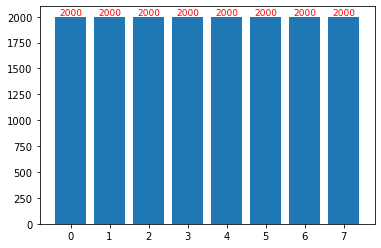

In [54]:
#분포 train
d_train = []
d_train2 = {}

for i in range(len(train_label_txts)):
    distribution(train_label_txts[i],d_train)

trainx, trainy = zip(*distribution2(d_train,d_train2))

grape(trainx, trainy)


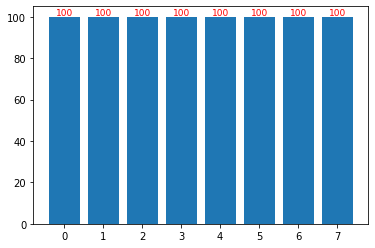

In [55]:
#분포 valid
d_valid = []
d_valid2 = {}

for i in range(len(valid_label_txts)):
    distribution(valid_label_txts[i],d_valid)

validx, validy = zip(*distribution2(d_valid,d_valid2))

grape(validx, validy)


# YOLOV5

In [ ]:
#git yolo / requirments
p = os.getcwd() 

%cd $p
!git clone https://github.com/ultralytics/yolov5

%cd yolov5
!pip install -r requirements.txt

In [ ]:
#yaml edit
import yaml

with open(p+'/datasets/data.yaml','r') as f:
    data = yaml.safe_load(f)

data['train'] = p + '\\datasets\\train\\images\\'
data['val'] = p + '\\datasets\\valid\\images\\'
data['nc'] = 8
data['names'] = ['normal','normal+', 'risk-1-1', 'risk-1-2', 'risk-1-3', 'risk-2-1', 'risk-2-2', 'risk-2-3']

with open(p+'/datasets/data.yaml','w') as f:
    yaml.dump(data,f)

In [ ]:
#train yolo
!python train.py --img 640 --batch 80 --epochs 300 --data $p/datasets/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name s  --cache

In [ ]:
!echo "# hyun3167" >> README.md
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M main
!git remote add origin https://github.com/Nbbang-Computer-science-team-project/hyun3167.git
!git push -u origin main

# CODE TEST

In [14]:
#데이터 / 데이터 정렬
t = os.getcwd() +'\datasets\\train\\labels\\'
v = os.getcwd() +'\datasets\\valid\\labels\\'
train_label_json = glob(p + '\\label\\label-t\\*')
valid_label_json = glob(p + '\\label\\label-v\\*')
train_label_txt = glob(p+'\\datasets\\train\\labels\\*')
valid_label_txt = glob(p+'\\datasets\\valid\\labels\\*')
train_img = glob(p+'\\datasets\\train\\images\\*')
valid_img = glob(p+'\\datasets\\valid\\images\\*')

train_img.sort()
valid_img.sort()
train_label_json.sort()
valid_label_json.sort()
train_label_txt.sort()
valid_label_txt.sort()

print(len(train_img),len(valid_img),len(train_label_json),len(valid_label_json),len(train_label_txt), len(valid_label_txt))

img_train_path = glob(p+'\\test\\train\\images\\*')
txt_train_path = glob(p+'\\test\\train\\labels\\*')

img_valid_path = glob(p+'\\test\\valid\\images\\*')
txt_valid_path = glob(p+'\\test\\valid\\labels\\*')

img_path_t = p +'\\test\\train\\images\\'
txt_path_t = p +'\\test\\train\\labels\\'

img_path_v = p +'\\test\\valid\\images\\'
txt_path_v = p +'\\test\\valid\\labels\\'

print(len(img_train_path), len(img_valid_path))
print('-----------------------------------------------------------------------------------------')
train_label_txts = glob(p+'\\test\\train\\labels\\*')
valid_label_txts = glob(p+'\\test\\valid\\labels\\*')
train_imgs = glob(p+'\\test\\train\\images\\*')
valid_imgs = glob(p+'\\test\\valid\\images\\*')

train_imgs.sort()
valid_imgs.sort()
train_label_txts.sort()
valid_label_txts.sort()


print(len(train_label_txts),len(valid_label_txts),len(train_imgs),len(valid_imgs))

18008 2059 18008 2059 0 0
16000 2743
-----------------------------------------------------------------------------------------
16000 2743 16000 2743
